In [1]:
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools # This allows us to mix and match
import random

from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

### Exploring our dataset

In [4]:
categories = os.listdir("cats")

In [5]:
counts = {}
for category in categories:
    counts[category] = len(os.listdir(os.path.join("cats",category)))

In [6]:
sorted(counts.items(), key=lambda x:x[1],reverse=True)

[('cat_sightings_0', 10),
 ('cat_sightings_1', 10),
 ('cat_sightings_4', 10),
 ('cat_sightings_5', 10),
 ('cat_sightings_6', 10),
 ('cat_sightings_7', 10),
 ('cat_sightings_12', 8),
 ('cat_sightings_2', 7),
 ('cat_sightings_8', 7),
 ('cat_sightings_10', 6),
 ('cat_sightings_11', 6),
 ('cat_sightings_3', 6),
 ('cat_sightings_13', 5),
 ('cat_sightings_9', 5)]

### Making Anchor, Positive and Negative dataset

In [29]:
# Getting all the images in a single folder/category

def get_image_paths(folder):
    return [os.path.join(folder,img) for img in os.listdir(folder)]

In [30]:
def create_triplets(dataset_path = "cats"):
    categories = os.listdir(dataset_path)
    triplets = [] # This will contain the image paths for our training set

    for category in categories:
        folder_path = os.path.join(dataset_path,category)
        images = get_image_paths(folder_path)

        # Getting paths in other category for pairing

        other_category = [os.path.join(dataset_path, other_category)for other_category in categories if other_category != category]   
        other_images = [get_image_paths(category) for category in other_category]
        other_images = list(itertools.chain.from_iterable(other_images))

        # Creating unique positive pairs
        positive_pairs = list(itertools.combinations(images,2))


        for pair in positive_pairs:
            anchor, positive = pair
            negative = random.choice(other_images)
            triplets.append((anchor,positive,negative))
    
    return triplets

    

In [31]:
triplets = create_triplets()

In [32]:
# Creating preprocessing function

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224)) # Target size matches the input size of the mobielnet
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array)

In [33]:
anchors, positives, negatives = [], [], []
for anchor_path, positive_path, negative_path in triplets:
    anchors.append(preprocess_image(anchor_path))
    positives.append(preprocess_image(positive_path))
    negatives.append(preprocess_image(negative_path))

# Convert to numpy arrays
anchors = np.vstack(anchors)
positives = np.vstack(positives)
negatives = np.vstack(negatives)

### Creating the model

In [18]:
from tensorflow.keras.applications import MobileNet

# Load pre-trained MobileNet without the top classification layer, freezing the weight
base_model = MobileNet(weights='imagenet', include_top=False)
base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model = Model(inputs=base_model.input, outputs=x)

In [19]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor = feature_extraction_model(input_anchor)
processed_positive = feature_extraction_model(input_positive)
processed_negative = feature_extraction_model(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1024], y_pred[:, 1024:2048], y_pred[:, 2048:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor, processed_positive, processed_negative])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=10, batch_size=32)


Epoch 1/10
13/13 [==============================] - 4s 40ms/step - loss: 9.9009
Epoch 2/10
13/13 [==============================] - 1s 38ms/step - loss: 9.9009
Epoch 3/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 4/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 5/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 6/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 7/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 8/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 9/10
13/13 [==============================] - 0s 36ms/step - loss: 9.9009
Epoch 10/10
13/13 [==============================] - 0s 32ms/step - loss: 9.9009


In [20]:
def extract_features(model, img_path):
    img = preprocess_image(img_path)  # Use the same preprocess function as during training
    features = model.predict(img)
    return features.flatten()  # Reshape to 1D array

In [22]:
# Test images
test_image_path1 = 'cats/cat_sightings_0/1.png'
test_image_path2 = 'cats\cat_sightings_7\sleepy_2.png'

# Extracting features
test_feature1 = extract_features(feature_extraction_model, test_image_path1)
test_feature2 = extract_features(feature_extraction_model, test_image_path2)

# Calculate Euclidean distance
from scipy.spatial.distance import euclidean
distance = euclidean(test_feature1, test_feature2)
print(distance)
# Define a threshold
threshold = 20 # Define based on your validation/testing

# Determine similarity
if distance < threshold:
    print("Images are similar.")
else:
    print("Images are not similar.")

1/1 [==============================] - 0s 15ms/step
27.731163024902344
Images are not similar.


#### Trying with MobileNetV2

In [47]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNet without the top classification layer, freezing the weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model_v2 = Model(inputs=base_model.input, outputs=x)

In [48]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v2 = feature_extraction_model_v2(input_anchor)
processed_positive_v2 = feature_extraction_model_v2(input_positive)
processed_negative_v2 = feature_extraction_model_v2(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1280], y_pred[:, 1280:2560], y_pred[:, 2560:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v2, processed_positive_v2, processed_negative_v2])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=32)


Epoch 1/25
13/13 [==============================] - 5s 41ms/step - loss: 14.6775
Epoch 2/25
13/13 [==============================] - 1s 46ms/step - loss: 14.6765
Epoch 3/25
13/13 [==============================] - 1s 44ms/step - loss: 14.6757
Epoch 4/25
13/13 [==============================] - 1s 42ms/step - loss: 14.6761
Epoch 5/25
13/13 [==============================] - 1s 42ms/step - loss: 14.6759
Epoch 6/25
13/13 [==============================] - 1s 41ms/step - loss: 14.6771
Epoch 7/25
13/13 [==============================] - 1s 42ms/step - loss: 14.6793
Epoch 8/25
13/13 [==============================] - 1s 41ms/step - loss: 14.6766
Epoch 9/25
13/13 [==============================] - 1s 41ms/step - loss: 14.6767
Epoch 10/25
13/13 [==============================] - 1s 40ms/step - loss: 14.6752
Epoch 11/25
13/13 [==============================] - 1s 41ms/step - loss: 14.6764
Epoch 12/25
13/13 [==============================] - 1s 41ms/step - loss: 14.6765
Epoch 13/25
13/13 [======

In [49]:
# Test images
test_image_path1 = 'cats/cat_sightings_0/1.png'
test_image_path2 = 'cats\cat_sightings_7\sleepy_2.png'

# Extracting features
test_feature1 = extract_features(feature_extraction_model_v2, test_image_path1)
test_feature2 = extract_features(feature_extraction_model_v2, test_image_path2)

# Calculate Euclidean distance
from scipy.spatial.distance import euclidean
distance = euclidean(test_feature1, test_feature2)
print(distance)
# Define a threshold
threshold = 20 # Define based on your validation/testing

# Determine similarity
if distance < threshold:
    print("Images are similar.")
else:
    print("Images are not similar.")

1/1 [==============================] - 0s 15ms/step
20.376535415649414
Images are not similar.


#### Trying EfficientNet B0 model out

In [50]:
import tensorflow as tf
from tensorflow import keras
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights = 'imagenet', include_top=False)

base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model_v3 = Model(inputs=base_model.input, outputs=x)

In [51]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v3 = feature_extraction_model_v3(input_anchor)
processed_positive_v3 = feature_extraction_model_v3(input_positive)
processed_negative_v3 = feature_extraction_model_v3(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1280], y_pred[:, 1280:2560], y_pred[:, 2560:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v3, processed_positive_v3, processed_negative_v3])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=32)

Epoch 1/25
13/13 [==============================] - 13s 58ms/step - loss: 1.6359
Epoch 2/25
13/13 [==============================] - 1s 57ms/step - loss: 1.6848
Epoch 3/25
13/13 [==============================] - 1s 57ms/step - loss: 1.6993
Epoch 4/25
13/13 [==============================] - 1s 57ms/step - loss: 1.5056
Epoch 5/25
13/13 [==============================] - 1s 57ms/step - loss: 1.4481
Epoch 6/25
13/13 [==============================] - 1s 57ms/step - loss: 1.6105
Epoch 7/25
13/13 [==============================] - 1s 57ms/step - loss: 1.7749
Epoch 8/25
13/13 [==============================] - 1s 57ms/step - loss: 1.5662
Epoch 9/25
13/13 [==============================] - 1s 57ms/step - loss: 1.8183
Epoch 10/25
13/13 [==============================] - 1s 57ms/step - loss: 1.7826
Epoch 11/25
13/13 [==============================] - 1s 58ms/step - loss: 1.5778
Epoch 12/25
13/13 [==============================] - 1s 57ms/step - loss: 1.6747
Epoch 13/25
13/13 [=================

#### Trying wiht MobileNetV2 but with more dense layers on the top

In [41]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 without the top classification layer, freezing the weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Flatten the output of the base model
flattened_output = Flatten()(base_model.output)

# Add three dense layers with 512 units each
dense_layer_1 = Dense(256, activation='relu')(flattened_output)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)

# Create the feature extraction model
feature_extraction_model_v4 = Model(inputs=base_model.input, outputs=dense_layer_3)


In [42]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v4 = feature_extraction_model_v4(input_anchor)
processed_positive_v4 = feature_extraction_model_v4(input_positive)
processed_negative_v4 = feature_extraction_model_v4(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        # Corrected slicing for 256-unit output
        num_features = 256  # Output size of the last dense layer
        anchor, positive, negative = y_pred[:, :num_features], y_pred[:, num_features:2*num_features], y_pred[:, 2*num_features:3*num_features]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v4, processed_positive_v4, processed_negative_v4])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
with tf.device('/GPU:0'):
    triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=16)

Epoch 1/25
26/26 [==============================] - 6s 28ms/step - loss: 1589.4200
Epoch 2/25
26/26 [==============================] - 1s 28ms/step - loss: 419.1479
Epoch 3/25
26/26 [==============================] - 1s 28ms/step - loss: 477.6729
Epoch 4/25
26/26 [==============================] - 1s 28ms/step - loss: 15.2001
Epoch 5/25
26/26 [==============================] - 1s 28ms/step - loss: 83.3557
Epoch 6/25
26/26 [==============================] - 1s 29ms/step - loss: 448.4117
Epoch 7/25
26/26 [==============================] - 1s 29ms/step - loss: 0.0000e+00
Epoch 8/25
26/26 [==============================] - 1s 28ms/step - loss: 0.0000e+00
Epoch 9/25
26/26 [==============================] - 1s 27ms/step - loss: 0.0000e+00
Epoch 10/25
26/26 [==============================] - 1s 26ms/step - loss: 0.0000e+00
Epoch 11/25
26/26 [==============================] - 1s 26ms/step - loss: 0.0000e+00
Epoch 12/25
26/26 [==============================] - 1s 27ms/step - loss: 0.0000e+00
Ep

#### Checking for results

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import product

def get_cosine(test_image_path1, test_image_path2, extraction_model):
    # Extracting features
    test_feature1 = extract_features(extraction_model, test_image_path1)
    test_feature2 = extract_features(extraction_model, test_image_path2)

    # Calculate cosine similarity
    similarity_score = cosine_similarity([test_feature1], [test_feature2])[0][0]

    # Define a similarity threshold
    threshold = 0.8

    return similarity_score >= threshold

In [14]:
def compute_accuracy(base_folder, extraction_model):
    folder_paths = [os.path.join(base_folder, f'cat_sightings_{i}') for i in range(14)]
    total_pairs = 0
    correct_predictions = 0

    # Iterate over all pairs of folders
    for folder1, folder2 in list(combinations(folder_paths, 2)) + list(product(folder_paths, repeat=2)):
        images1 = [os.path.join(folder1, img) for img in os.listdir(folder1) if img.endswith('.jpg')]
        images2 = [os.path.join(folder2, img) for img in os.listdir(folder2) if img.endswith('.jpg')]
        
        # Test all combinations of images between the two folders
        for img1, img2 in product(images1, images2):
            same_class = (folder1 == folder2)
            same_image = get_cosine(img1, img2, extraction_model)
            total_pairs += 1
            
            # Correct prediction if both images are from the same class and found similar, or from different classes and not similar
            if same_image == same_class:
                correct_predictions += 1

    accuracy = correct_predictions / total_pairs
    return accuracy


In [56]:
accuracy = compute_accuracy('cats', feature_extraction_model)


1/1 [==============================] - 0s 14ms/step


In [57]:
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.79


In [58]:
accuracy1 = compute_accuracy('cats', feature_extraction_model_v2)

1/1 [==============================] - 0s 21ms/step


In [59]:
print(f'Accuracy: {accuracy1:.2f}')

Accuracy: 0.79


In [60]:
accuracy2 = compute_accuracy('cats', feature_extraction_model_v3)

1/1 [==============================] - 0s 18ms/step


In [61]:
print(f'Accuracy: {accuracy2:.2f}')

Accuracy: 0.26


In [62]:
accuracy3 = compute_accuracy('cats', feature_extraction_model_v4)

1/1 [==============================] - 0s 16ms/step


In [63]:
print(f'Accuracy: {accuracy3:.2f}')

Accuracy: 0.96


In [43]:
accuracy3 = compute_accuracy('cats', feature_extraction_model_v4)

1/1 [==============================] - 0s 16ms/step


In [44]:
print(f'Accuracy: {accuracy3:.2f}')

Accuracy: 0.99


#### Plotting the images with the metrics

In [71]:
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [72]:
def get_euclidean_plot(test_image_path1,test_image_path2, extraction_model):
    # Extracting features
    test_feature1 = extract_features(extraction_model, test_image_path1)
    test_feature2 = extract_features(extraction_model, test_image_path2)

    # Calculate Euclidean distance
    distance = euclidean(test_feature1, test_feature2)
    print("Euclidean Distance:", distance)

    # Define a threshold
    threshold = 20 # Define based on your validation/testing

    # Load and plot the images
    img1 = mpimg.imread(test_image_path1)
    img2 = mpimg.imread(test_image_path2)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Image 1')
    axes[1].imshow(img2)
    axes[1].set_title('Image 2')

    # Determine similarity and display the result
    if distance < threshold:
        result = "Images are similar."
    else:
        result = "Images are not similar."

    # Add the distance as a text annotation
    fig.suptitle(result + f'\nEuclidean Distance: {distance:.2f}', fontsize=12)
    plt.show()


In [38]:
def get_cosine_plot(test_image_path1,test_image_path2,extraction_model):
    # Extracting features
    test_feature1 = extract_features(extraction_model, test_image_path1)
    test_feature2 = extract_features(extraction_model, test_image_path2)

    # Calculate cosine similarity
    similarity_score = cosine_similarity([test_feature1], [test_feature2])[0][0]
    print("Cosine Similarity Score:", similarity_score)

    # Define a similarity threshold (adjust as needed)
    threshold = 0.8  # You can set this threshold based on your validation/testing

    # Load and plot the images
    img1 = mpimg.imread(test_image_path1)
    img2 = mpimg.imread(test_image_path2)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Image 1')
    axes[1].imshow(img2)
    axes[1].set_title('Image 2')

    # Determine similarity and display the result
    if similarity_score >= threshold:
        result = "Images are similar."
    else:
        result = "Images are not similar."

    # Add the similarity score as a text annotation
    fig.suptitle(result + f'\nCosine Similarity Score: {similarity_score:.2f}', fontsize=12)
    plt.show()


##### Test 1 with same cat

1/1 [==============================] - 0s 19ms/step
Cosine Similarity Score: 0.7189626


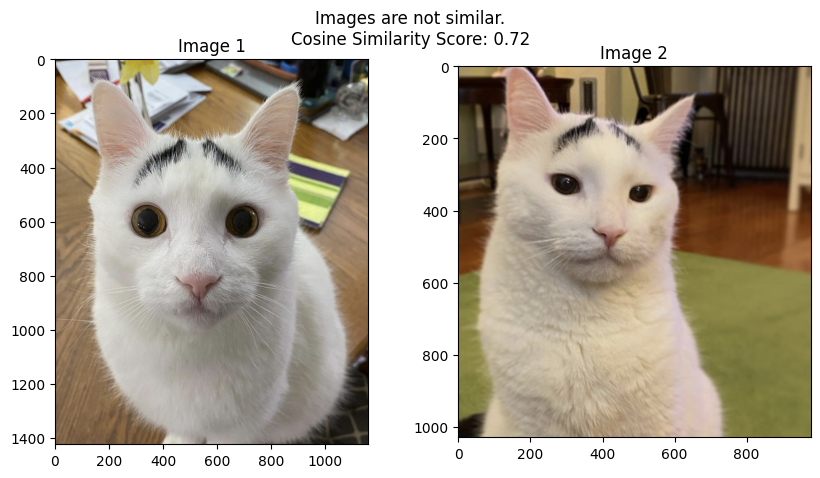

In [75]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats/cat_sightings_0/2.png',feature_extraction_model_v2)

1/1 [==============================] - 0s 19ms/step
Cosine Similarity Score: 0.9992249


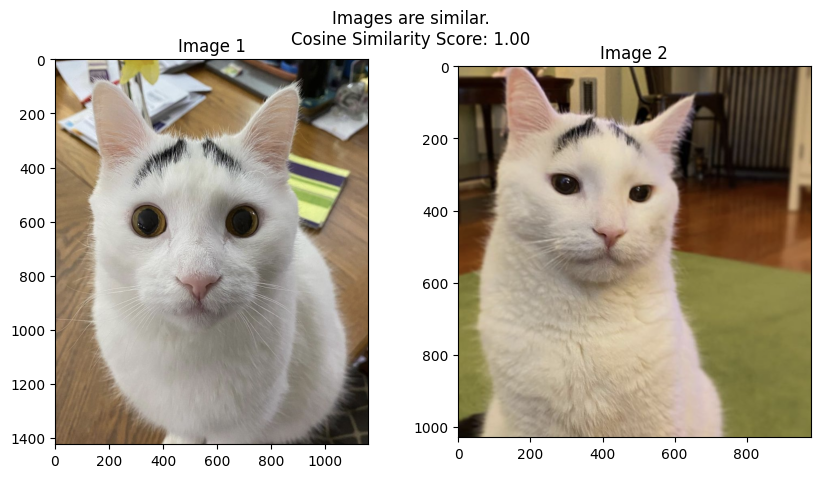

In [76]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats/cat_sightings_0/2.png',feature_extraction_model_v3)

1/1 [==============================] - 0s 17ms/step
Cosine Similarity Score: 0.96922445


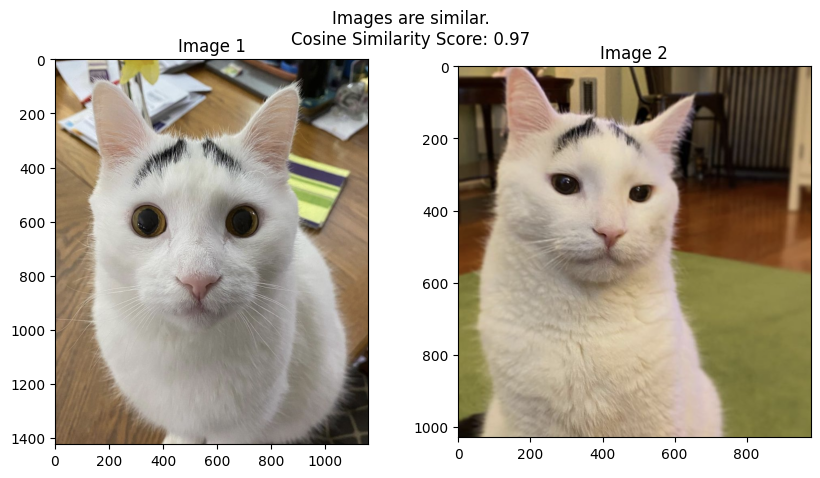

In [ ]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats/cat_sightings_0/2.png',feature_extraction_model_v4)

##### Test 2 with different cat

1/1 [==============================] - 0s 14ms/step
Cosine Similarity Score: 0.6043484


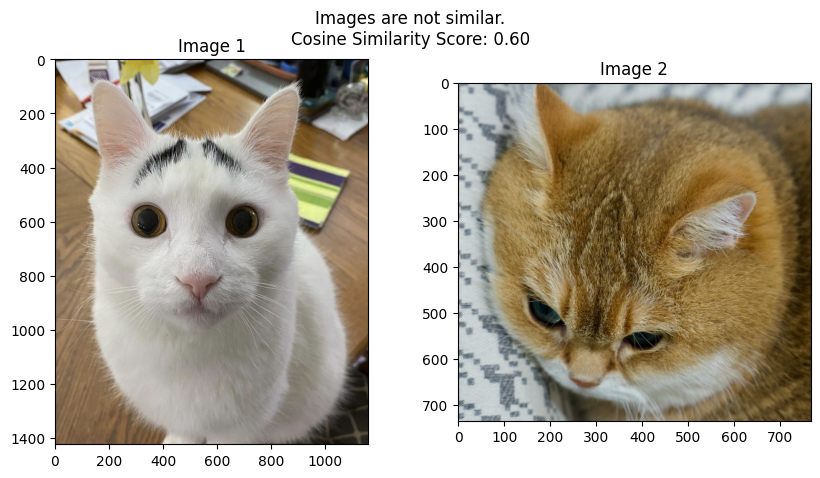

In [77]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_7\sleepy_2.png',feature_extraction_model)

1/1 [==============================] - 0s 16ms/step
Cosine Similarity Score: 0.55759084


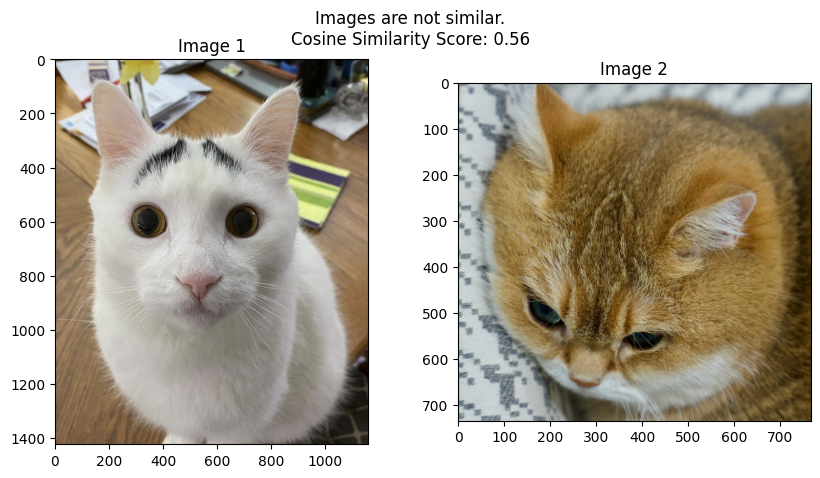

In [78]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_7\sleepy_2.png',feature_extraction_model_v2)

1/1 [==============================] - 0s 19ms/step
Cosine Similarity Score: 0.99925643


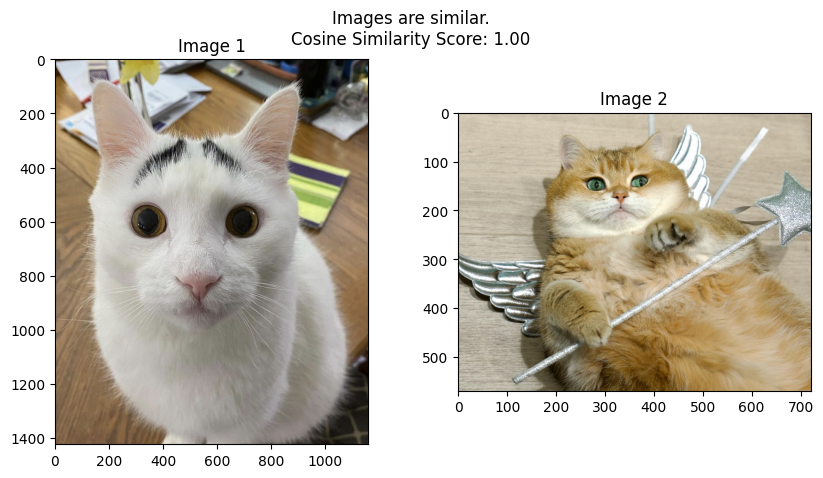

In [79]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_7\sleepy_3.png',feature_extraction_model_v3)

1/1 [==============================] - 0s 17ms/step
Cosine Similarity Score: 0.2819748


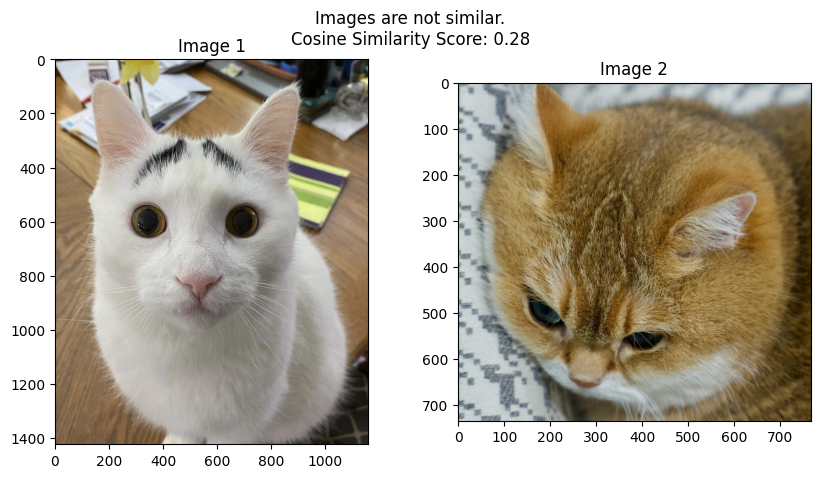

In [65]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_7\sleepy_2.png',feature_extraction_model_v4)

#### Saving the model

In [56]:
feature_extraction_model_v4.save("main.model")

INFO:tensorflow:Assets written to: main.model\assets


INFO:tensorflow:Assets written to: main.model\assets


In [69]:
from tensorflow.keras.models import load_model
main = load_model("main.model")

1/1 [==============================] - 0s 19ms/step
Cosine Similarity Score: 0.2819748


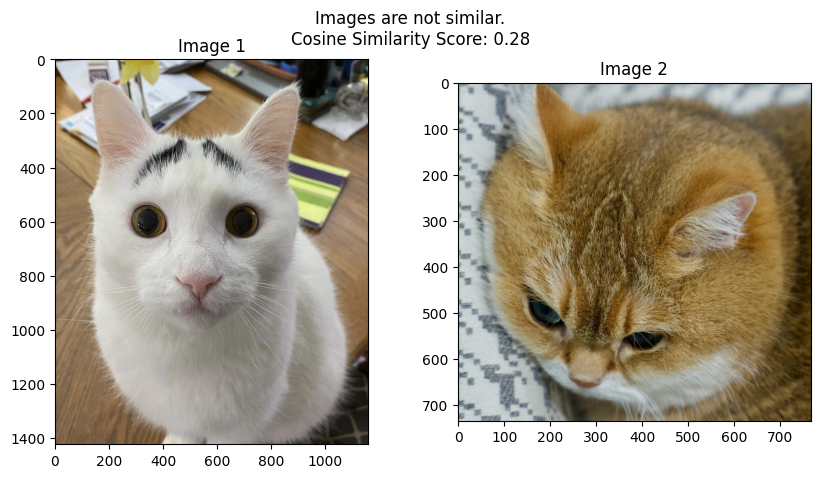

In [70]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_7\sleepy_2.png',main)

1/1 [==============================] - 0s 17ms/step
Cosine Similarity Score: 0.970304


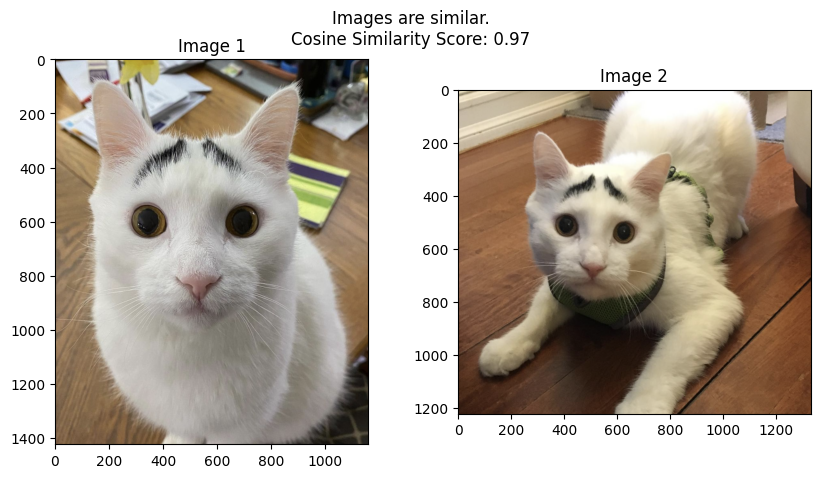

In [59]:
get_cosine_plot('cats/cat_sightings_0/1.png','cats\cat_sightings_0\8.png',main)

1/1 [==============================] - 0s 18ms/step
Cosine Similarity Score: 0.5767406


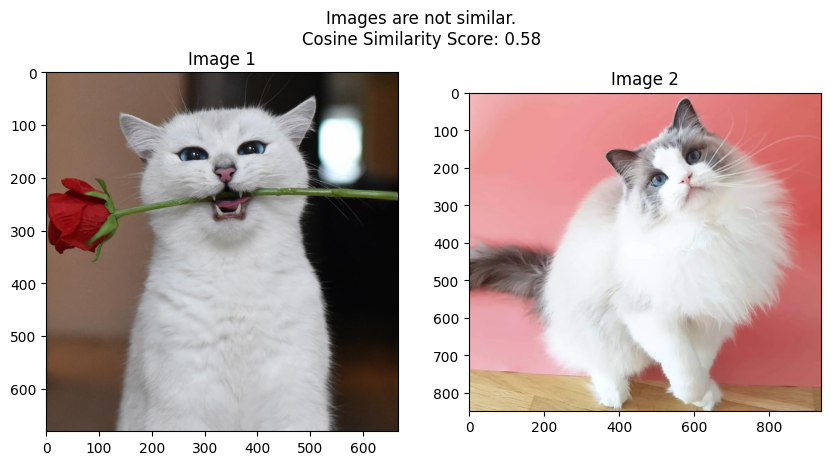

In [60]:
get_cosine_plot('cats\cat_sightings_6\Sapphire_8.png','cats\cat_sightings_12\\aurora_2.png',main)

In [71]:
import requests
from PIL import Image
from io import BytesIO

In [72]:
def preprocess_image(img_url):
    # Fetch the image from the URL
    response = requests.get(img_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch image from URL: {img_url}")

    # Read the image content
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 

    # Resize and process the image as before
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array)

def extract_features(model, img_url):
    img = preprocess_image(img_url)  # Updated to use img_url
    features = model.predict(img)
    return features.flatten()

In [73]:
from datetime import datetime, timedelta
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobSasPermissions
import pandas as pd

container_name = 'images'

#create a client to interact with blob storage
connect_str = "DefaultEndpointsProtocol=https;AccountName=scsimages;AccountKey=g4wHq2sGKX0nNm9JSNo6LEwtq1yorhbnMG8bXkNvvTXtJHEld6fkaq4wTJ3H4NiM0YtqERxNmAxA+AStdaq8IQ==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
#use the client to connect to the container
container_client = blob_service_client.get_container_client(container_name)

In [74]:
images = [blob_i.name for blob_i in container_client.list_blobs()]

In [75]:
URL_PATH = "https://scsimages.blob.core.windows.net/images/"

In [78]:
embeddings = [list(extract_features(main,URL_PATH + image)) for image in images]

1/1 [==============================] - 0s 16ms/step


In [79]:
df = pd.DataFrame(
    {"fileName": images,
    "Vectors": embeddings
    })

df.to_csv("Embeddings.csv",index = False)